# Deep Learning

## Part 2: Open Task - Part Of Speech Tagging (Custom Architecture)

---

> Kostis Konstantinos (p3352311) <br>
> Karousis Nikolaos (p3352321) <br>
> MSc Data Science (Part-Time) <br>
> Athens University Of Economics and Business

## Open Task

For the part 2 of the assignment the open task was selected, which is about part-of-speech tagging.

This notebook implements the custom architecture of the POS Tagging task.

## Dataset description
The dataset used, refers to the english language of the Universal Dependencies tree banks and more specifically GUM from Georgetown University. It contains 10761 sentences from different genres: academic, blog, fiction, government, news, nonfiction, social, spoken, web, wiki. The dataset is downloaded from Github and parsed using the conllu package, via a custom class named DatasetHandler.

- Treebank index page can be found here https://universaldependencies.org/treebanks/en_gum/index.html
- The actual data (train, dev, test) files can be found at https://github.com/UniversalDependencies/UD_English-GUM/tree/master

In [1]:
# Install needed libraries
!pip install -U conllu gensim requests tensorflow==2.12.0 keras-tuner==1.4.7 pandas==1.5.3 numpy==1.23.5 scikit-learn==1.3.0 matplotlib==3.8.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 112.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 75.2 MB/s eta 0:00:00


In [1]:
## Allow access to the code directory
import sys
import os
from google.colab import drive

# Mount the drive
drive.mount('/content/drive', force_remount=True)

# Define the base path
base_path = '/content/drive/MyDrive/deep-learning-msc-data-science-2024-2025'

# Define the code path
code_folder = os.path.join(base_path, 'code')

# Add the 'code' folder to the sys.path
sys.path.append(code_folder)

Mounted at /content/drive


In [2]:
# Load libraries

from constants import *
from pos_utils import *
from pos_custom import *


## Fetch/Load the data

In [3]:
data_directory = os.path.join(base_path, 'data', 'pos_en_gmu')

train_ds_handler = DatasetHandler(data_directory, POS_TAG_TRAIN_URL, 'train')
train_ds_handler.fetch()

dev_ds_handler = DatasetHandler(data_directory, POS_TAG_DEV_URL, 'dev')
dev_ds_handler.fetch()

test_ds_handler = DatasetHandler(data_directory, POS_TAG_TEST_URL, 'test')
test_ds_handler.fetch()

## Basic statistics
Below you can find some basic statistics regarding the train, dev and test sets. Reported statistics are:

- Dataset split
- Number of sentences
- Average sentence length
- Number of words
- Number of unique words

In [4]:
train_stats = train_ds_handler.basic_stats()
dev_stats = dev_ds_handler.basic_stats()
test_stats = test_ds_handler.basic_stats()

stats = pd.concat([train_stats, dev_stats, test_stats], ignore_index=True)

stats

,Dataset,Sentences,Average Sentence Length,Words,Unique Words
0,train,9520,17.5,166918,15555
1,dev,1341,18.2,24375,4302
2,test,1285,18.9,24331,4820


## Initialize a DatasetProcessor and fit() on the train sentences

Note that here we only fit the processor here. This means that we only
learn the vocabulary by storing a mapping (word2idx) and also encode the labels (tag2idx).

Additionally, the vocabulary is augmented with two special tokens **"<PAD>"** and **"<UNK>"** and also augment the tags with a **"<PAD>** signified by a zero (0).

Note that, the classes below:
  - RNNPosTaggerTuner
  - RNNPosTagger

call the transform() method of the data processor to properly encode and pad the input data.

In [5]:
data_processor = DatasetProcessor()
data_processor.fit(train_ds_handler.sentences)

print("Max Sequence Length: {}".format(data_processor.max_sequence_length))

Max Sequence Length: 112


## Construct the embeddings matrix

The word embeddings given to the RNN are backed by the Glove-100d vectors, exposed via Gensim's API.

In [6]:
embeddings_wrapper = GloveEmbeddings(data_processor.word2idx, model_name='glove-wiki-gigaword-100')
embedding_matrix = embeddings_wrapper.embedding_matrix
embedding_matrix.shape

[==================================================] 100.0% 128.1/128.1MB downloaded


(15557, 100)

## Hyper-Parameter Tuning

In [7]:
tuner_directory = os.path.join(base_path, TUNERS_DIR)
pos_rnn_tuner = RNNPosTaggerTuner(tuner_directory, POS_TAG_CUSTOM_TUNER_PROJECT_NAME,
                                  train_ds_handler.sentences, dev_ds_handler.sentences,
                                  data_processor, embedding_matrix,
                                  n_stacked=3, train_size=0.4)

In [8]:
keras_pos_rnn_tuner = pos_rnn_tuner.tune(batch_size=64, epochs=15, max_trials=5, patience=3)

Trial 5 Complete [00h 02m 08s]
val_loss: 0.767382800579071

Best val_loss So Far: 0.30982673168182373
Total elapsed time: 00h 13m 44s


In [9]:
best_hyperparams = keras_pos_rnn_tuner.get_best_hyperparameters()[0].values
best_hyperparams

{'dropout_layer_first': 0.2,
 'num_layers': 2,
 'gru_units_0': 192,
 'dropout_layer_0': 0.15000000000000002,
 'dense_units': 256,
 'dropout_layer_last': 0.2,
 'learning_rate': 0.01,
 'gru_units_1': 96,
 'dropout_layer_1': 0.5}

## Model Architecture Summary


In [10]:
keras_pos_rnn_tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 112, 100)          1555700   
                                                                 
 dropout (Dropout)           (None, 112, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 112, 384)         338688    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 112, 384)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 112, 192)         277632    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 112, 192)          0

## Fit the RNN

In [11]:
models_directory = os.path.join(base_path, MODELS_DIR)
rnn_pos_tagger = RNNPosTagger(models_directory, POS_TAG_CUSTOM_WEIGHTS,
                              data_processor, embedding_matrix)

In [12]:
rnn_pos_tagger.fit(train_ds_handler.sentences, dev_ds_handler.sentences, best_hyperparams, batch_size=128, epochs=100)

Epoch 1/100
42/42 [==============================] - 8s 60ms/step
 — val_f1: 0.870453 — val_precision: 0.872421 — val_recall: 0.874872

Epoch 1: val_f1 improved from -inf to 0.87045, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_custom.weights.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


75/75 [==============================] - 61s 597ms/step - loss: 1.0764 - categorical_accuracy: 0.6751 - val_loss: 0.3740 - val_categorical_accuracy: 0.8749 - val_f1: 0.8705 - val_recall: 0.8749 - val_precision: 0.8724
Epoch 2/100
42/42 [==============================] - 2s 57ms/step
 — val_f1: 0.903702 — val_precision: 0.904312 — val_recall: 0.905272

Epoch 2: val_f1 improved from 0.87045 to 0.90370, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_custom.weights.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


75/75 [==============================] - 35s 463ms/step - loss: 0.4287 - categorical_accuracy: 0.8614 - val_loss: 0.2745 - val_categorical_accuracy: 0.9053 - val_f1: 0.9037 - val_recall: 0.9053 - val_precision: 0.9043
Epoch 3/100
42/42 [==============================] - 2s 58ms/step
 — val_f1: 0.910225 — val_precision: 0.914560 — val_recall: 0.913272

Epoch 3: val_f1 improved from 0.90370 to 0.91022, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025/models/pos_tag_custom.weights.h5
75/75 [==============================] - 35s 464ms/step - loss: 0.3366 - categorical_accuracy: 0.8904 - val_loss: 0.2503 - val_categorical_accuracy: 0.9133 - val_f1: 0.9102 - val_recall: 0.9133 - val_precision: 0.9146
Epoch 4/100
42/42 [==============================] - 2s 58ms/step
 — val_f1: 0.916214 — val_precision: 0.919600 — val_recall: 0.919344

Epoch 4: val_f1 improved from 0.91022 to 0.91621, saving model to /content/drive/MyDrive/deep-learning-msc-data-science-2024-2025

In [13]:
rnn_pos_tagger.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 112, 100)          1555700   
                                                                 
 dropout_4 (Dropout)         (None, 112, 100)          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 112, 384)         338688    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 112, 384)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 112, 192)         277632    
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 112, 192)         

## Plot training accuracy and loss curves

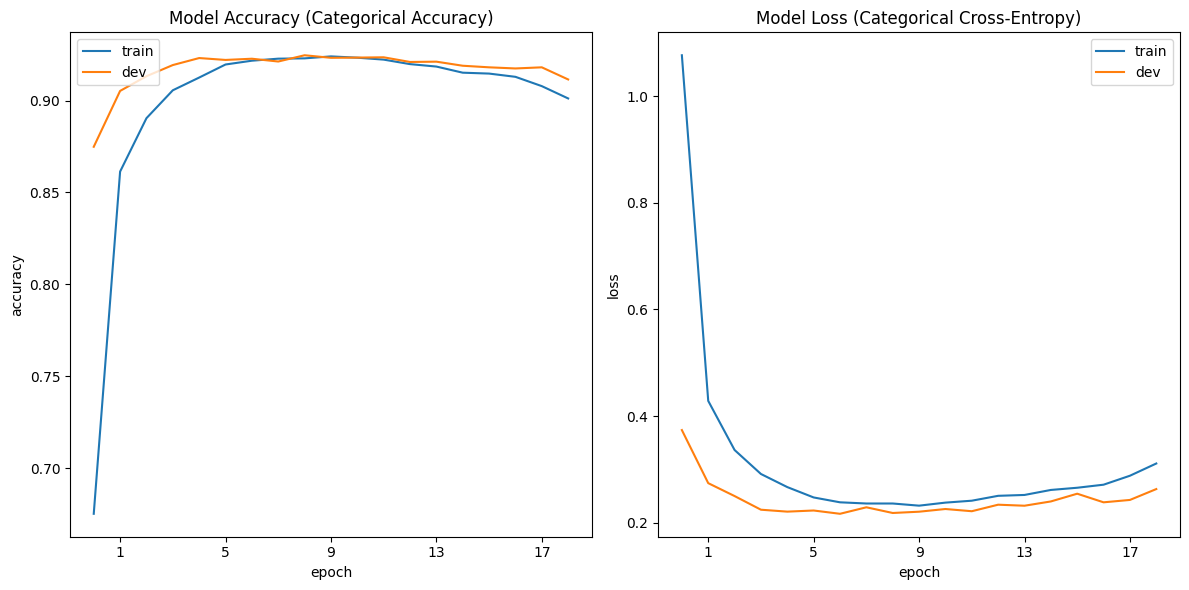

In [14]:
rnn_pos_tagger.plot_curves()

## Evaluate the RNN tagger on the training set (classification report)

In [15]:
train_set = train_ds_handler.sentences
train_classification_report_df, train_macro_average_df = rnn_pos_tagger.classification_report(train_set)

298/298 [==============================] - 17s 58ms/step


In [16]:
train_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,ADP,0.968514,0.979904,0.974176,0.996833
1,2,X,0.949640,0.416404,0.578947,0.771372
2,3,PRON,0.991648,0.989564,0.990605,0.999314
3,4,VERB,0.966468,0.960789,0.963620,0.993366
4,5,ADJ,0.942892,0.921869,0.932262,0.980953
5,6,CCONJ,0.994609,0.992579,0.993593,0.999446
6,7,DET,0.993380,0.990771,0.992074,0.999508
7,8,_,0.993984,0.999644,0.996806,0.999650
8,9,AUX,0.986482,0.992745,0.989603,0.999058
9,10,PART,0.979495,0.995679,0.987520,0.999073


In [17]:
train_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.952885,0.928387,0.934447,0.975263


## Evaluate the RNN tagger on the validation set (classification report)

In [18]:
dev_set = dev_ds_handler.sentences
dev_classification_report_df, dev_macro_average_df = rnn_pos_tagger.classification_report(dev_set)

42/42 [==============================] - 2s 56ms/step


In [19]:
dev_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,ADP,0.946649,0.964510,0.955496,0.988403
1,2,X,0.800000,0.333333,0.470588,0.363171
2,3,PRON,0.986380,0.985081,0.985730,0.995321
3,4,VERB,0.878393,0.906951,0.892443,0.967870
4,5,ADJ,0.858350,0.833965,0.845981,0.931911
5,6,CCONJ,0.989078,0.984300,0.986683,0.998965
6,7,DET,0.989926,0.984705,0.987308,0.999188
7,8,_,0.993377,0.989011,0.991189,0.997648
8,9,AUX,0.981591,0.985218,0.983401,0.998416
9,10,PART,0.950581,0.989410,0.969607,0.996670


In [20]:
dev_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.91305,0.844259,0.866145,0.909148


## Evaluate the RNN tagger on the test set (classification report)

In [21]:
test_set = test_ds_handler.sentences
test_classification_report_df, test_macro_average_df = rnn_pos_tagger.classification_report(test_set)

41/41 [==============================] - 2s 57ms/step


In [22]:
test_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,ADP,0.947514,0.969709,0.958483,0.991779
1,2,X,1.000000,0.125000,0.222222,0.467995
2,3,PRON,0.983954,0.983391,0.983672,0.998540
3,4,VERB,0.833519,0.905531,0.868034,0.958636
4,5,ADJ,0.842929,0.831995,0.837426,0.924028
5,6,CCONJ,0.989157,0.980884,0.985003,0.999175
6,7,DET,0.988604,0.988135,0.988369,0.999364
7,8,_,0.990712,0.981595,0.986133,0.996730
8,9,AUX,0.976667,0.985702,0.981164,0.997671
9,10,PART,0.927405,0.984586,0.955140,0.991500


In [23]:
test_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.91209,0.836935,0.850873,0.909423


## Remarks

- The model performs terribly with respect to class `X` (more info [here](https://universaldependencies.org/treebanks/en_gum/en_gum-pos-X.html)) as PR-AUC reports around 46%. This is a very difficult class since it contains tokens like `et`, `al`, `de`, `1` (like part 1 of 2), `1.` and others.

- The loss curves do not show signs of strong overfitting (see the validation loss curve)